In [27]:
import numpy as np
import pandas as pd
import torch
# from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
import gensim
import random
from gensim.test.utils import common_texts
from gensim.models import Word2Vec
from torch.utils.data.sampler import WeightedRandomSampler
from sklearn.metrics import confusion_matrix
import seaborn as sn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

# Load the data

In [72]:
# Combine the offensive and hate languages
data = pd.read_csv("/content/data_processed.csv")
data['class'] = data['class'].replace(0, 1)
data['class'] = data['class']-1
data

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,1,as a woman you shouldnt complain about cleani...
1,1,3,0,3,0,0,boy dats coldtyga dwn bad for cuffin dat hoe ...
2,2,3,0,3,0,0,dawg you ever fuck a bitch and she start to c...
3,3,3,0,2,1,0,she look like a tranny
4,4,6,0,6,0,0,the shit you hear about me might be true or i...
...,...,...,...,...,...,...,...
24768,25291,3,0,2,1,0,yous a muthafin lie right his tl is trash now ...
24769,25292,3,0,1,2,1,youve gone and broke the wrong heart baby and ...
24770,25294,3,0,3,0,0,young buck wanna eat dat nigguh like i aint fu...
24771,25295,6,0,6,0,0,youu got wild bitches tellin you lies


In [73]:
# model = SentenceTransformer('all-MiniLM-L6-v2')
sentences = data["tweet"]
# sentence_embeddings = model.encode(sentences)
words = [list(s.lower().split()) for s in sentences]

In [74]:
w2v = Word2Vec(sentences=words, size=384, window=5, min_count=1, workers=4)

# import gensim.downloader as api
# corpus = api.load('text8')  # download the corpus and return it opened as an iterable
# w2v = Word2Vec(corpus)
# w2v.train(sentences=words)

sentence_embeddings = [torch.as_tensor([w2v.wv[word] for word in list(s.lower().split())]) for s in sentences]

In [75]:
label = np.array(data['class'])

# Train-validation-test split

In [76]:
def create_train_and_test_set_balanced(X, y, train_ratio=0.8):
    # TODO
    # process the list of (x,y) pairs and split them 80-20 into train and test set
    # train_x is a list of name embeddings each of size (num_characters_in_name, 1, n_letters), train_y is the corresponding list of language category index. Same for test_x and test_y

    X, X_rem, y, y_rem = X[0:int(train_ratio * len(X))], X[int(train_ratio * len(X)) + 1:-1], y[0:int(train_ratio * len(y))], y[int(train_ratio * len(y)) + 1:-1]
    
    counts = np.bincount(y)
    label_weights = 1.0 / counts
    weights = label_weights[y]
    index = list(WeightedRandomSampler(weights, len(weights)))
    X_train, y_train = [X[i] for i in index], [y[i] for i in index]

    return X_train, X_rem, y_train, y_rem

In [77]:
X_train, X_rem, y_train, y_rem = create_train_and_test_set_balanced(sentence_embeddings,label)
X_valid, X_test, y_valid, y_test = create_train_and_test_set_balanced(X_rem,y_rem)

In [78]:
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

class Tweet(Dataset):
    def __init__(self, X,y, transform=None):
        self.X = pad_sequence(X,batch_first=True)
        self.y = torch.as_tensor(np.array(y))
        self.transform = transform

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        sentence = self.X[idx]
        label = self.y[idx]
        sample = {'sentence': sentence, 'label': label}

        if self.transform:
            sample = self.transform(sample)

        return sample

# Define the model

In [79]:
hidden_size = 128
output_size = 3
batch_size = 50

valid_losses = []

In [80]:
train_data = Tweet(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0,drop_last=True)

valid_data = Tweet(X_valid, y_valid)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=True, num_workers=0,drop_last=True)

test_data = Tweet(X_test, y_test)
test_loader = DataLoader(test_data, batch_size=len(X_test), shuffle=True, num_workers=0,drop_last=True)

In [86]:
from sklearn.preprocessing import normalize
import torch.nn as nn
import torch
from torch.autograd import Variable


class lstm(nn.Module):
    def __init__(self, embedding_length=384,dropout=0.3):
        super(lstm, self).__init__()

        self.dropout = dropout
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.batch_size = batch_size
        self.fc1 = nn.Linear(embedding_length, 256)
        self.lstm = nn.LSTM(embedding_length, self.hidden_size,batch_first=True,dropout=dropout, num_layers=1)
        self.fc2 = nn.Linear(self.hidden_size, self.hidden_size//2)
        self.fc3 = nn.Linear(self.hidden_size//2, self.hidden_size//4)
        self.label = nn.Linear(self.hidden_size//4, self.output_size)
        self.relu = nn.ReLU()
        self.to("cuda")


    def forward(self,input):

        input = input.to("cuda")

        # input = self.fc1(input)
        # input = self.relu(input)

        h_0 = Variable(torch.zeros(1, len(input), self.hidden_size).cuda())
        c_0 = Variable(torch.zeros(1, len(input), self.hidden_size).cuda())


        output, (final_hidden_state, final_cell_state) = self.lstm(input, (h_0, c_0))
        x = self.fc2(final_hidden_state[-1])
        x = self.fc3(x)

        return self.label(x)
    

    def fit(self, train_loader, epochs=300,lr=1e-5,interval=100):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        scheduler = ReduceLROnPlateau(optimizer, patience=50, threshold=1e-3)


        for epoch in range(epochs):
            running_loss = 0.0
            self.train()

            for i_batch, sample in enumerate(train_loader):
                sentences, labels = sample['sentence'].to("cuda"), sample['label'].to("cuda")

                outputs = self(sentences)
                loss = criterion(
                    outputs,
                    labels,
                )

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

                if i_batch % interval == 0 and i_batch > 0:
                    valid_loss = self.validate(valid_loader=valid_loader)
                    print(f"epoch:{epoch},batch: {i_batch}, train_loss: {running_loss/interval}, valid_loss: {valid_loss}")
                    running_loss = 0
            scheduler.step(self.validate(valid_loader))
            valid_losses.append([epoch,self.validate(valid_loader)])

    def validate(self, valid_loader):
        running_loss = 0
        val_count = 0
        # self.eval()
        criterion = torch.nn.CrossEntropyLoss()

        for i_batch, sample in enumerate(valid_loader):
            sentences, labels = sample['sentence'].to("cuda"), sample['label'].to("cuda")

            outputs = self(sentences)
            loss = criterion(
                outputs,
                labels,
            )

            running_loss += loss.item()
            val_count += 1

        avg_loss = running_loss / val_count
        return avg_loss

    def accuracy(self,test_loader):
        self.eval()
        plt.figure(figsize=(10, 10))
        for i_batch, sample in enumerate(test_loader):
            sentences, labels = sample['sentence'], sample['label']
    
            outputs = self(sentences)
            pred = np.array([np.argmax(outputs[i].cpu().detach().numpy()) for i in range(len(outputs))])
            assert len(pred) == len(labels)
            cm = pd.DataFrame(confusion_matrix(labels,pred,normalize="true"),index=["True offensive","True non-offensive"],columns=["Predicted offensive","Predicted non-offensive"])
            
            sn.heatmap(data=cm,annot=True,xticklabels=True,yticklabels=True)
            plt.show()

            return np.sum(labels.numpy() == pred) / len(pred)


    def predict(self,sentence):
        vec = torch.as_tensor([w2v.wv[word] for word in list(sentence.lower().split())])
        vec = vec.unsqueeze(0)
        index =  np.argmax(self(vec).cpu().detach().numpy()) 
        index = [np.argmax(r) for r in index]

        # label_to_senti = {0:"hate speech",1:"offensive language",2:"neither"}
        label_to_senti = {0:"offensive",1:"normal"}
        return label_to_senti[index]

    def metrics(self,test_loader):
        self.eval()
        plt.figure(figsize=(10, 10))
        for i_batch, sample in enumerate(test_loader):
            sentences, labels = sample['sentence'], sample['label']
    
            outputs = self(sentences)
            pred = np.array([np.argmax(outputs[i].cpu().detach().numpy()) for i in range(len(outputs))])
            assert len(pred) == len(labels)
            accuracy = accuracy_score(labels, pred)
            precision = precision_score(labels, pred, pos_label=0)
            recall = recall_score(labels, pred, pos_label=0)
            f1 = f1_score(labels, pred, pos_label=0)
            RocCurveDisplay.from_predictions(labels, pred, name="LSTM")
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.show()
            print(f"Accuracy={accuracy}\nPrecision={precision}\nRecall={recall}\nF1={f1}")

            

In [87]:
lstm_model = lstm()
valid_losses = []
lstm_model.fit(train_loader=train_loader)

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


epoch:0,batch: 100, train_loss: 1.1629631638526916, valid_loss: 1.1439891947975642
epoch:0,batch: 200, train_loss: 1.1357408201694488, valid_loss: 1.128324409074421
epoch:0,batch: 300, train_loss: 1.1189956724643708, valid_loss: 1.109301763244822
epoch:1,batch: 100, train_loss: 1.0614467579126359, valid_loss: 0.9893659790859947
epoch:1,batch: 200, train_loss: 0.8566471272706986, valid_loss: 0.7583079413522648
epoch:1,batch: 300, train_loss: 0.7356837797164917, valid_loss: 0.719954369188864
epoch:2,batch: 100, train_loss: 0.7141463506221771, valid_loss: 0.7045826904381378
epoch:2,batch: 200, train_loss: 0.7031565886735917, valid_loss: 0.7016292418105693
epoch:2,batch: 300, train_loss: 0.7008812820911408, valid_loss: 0.6998272545730011
epoch:3,batch: 100, train_loss: 0.7054405528306961, valid_loss: 0.6979590692097628
epoch:3,batch: 200, train_loss: 0.6975140279531479, valid_loss: 0.6972659615021718
epoch:3,batch: 300, train_loss: 0.6971563363075256, valid_loss: 0.6965355593946916
epoch:4

Text(0, 0.5, 'valid loss')

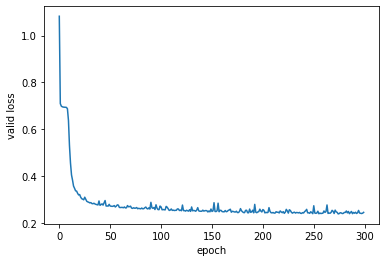

In [88]:
import matplotlib.pyplot as plt
plt.plot(np.array(valid_losses)[:,0],np.array(valid_losses)[:,1])
plt.xlabel("epoch")
plt.ylabel("valid loss")

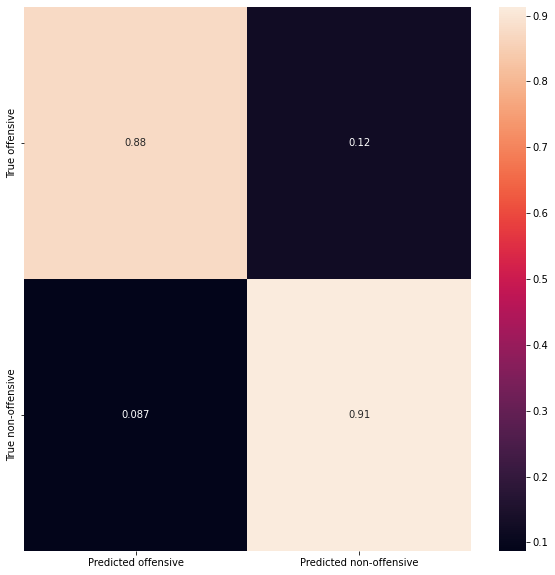

0.8816986855409504

In [89]:
lstm_model.accuracy(test_loader)

<Figure size 720x720 with 0 Axes>

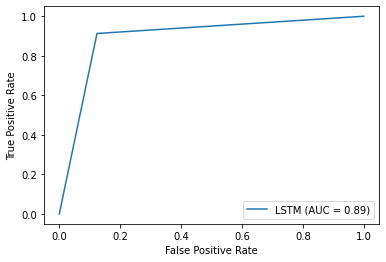

Accuracy=0.8816986855409504
Precision=0.9826435246995995
Recall=0.8761904761904762
F1=0.9263687853996223


In [90]:
lstm_model.metrics(test_loader) 